# Sequential learning for non-stationary classification

In [1]:
import jax
import distrax
import einops
import seaborn as sns
import flax.linen as nn
import numpy as np
import pandas as pd
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tqdm import tqdm
from functools import partial
from moons_data import make_rotating_moons
from rebayes_mini.methods.gauss_filter import BernoulliFilter
from rebayes_mini.methods.gauss_filter import GaussianFilter
from rebayes_mini.methods.adaptive import ExpfamRLPR

In [2]:
from matplotlib.animation import FuncAnimation

In [3]:
%config InlineBackend.figure_format = "retina"
plt.rc("text", usetex=False)
sns.set_palette("colorblind")
plt.rcParams["axes.spines.right"]= False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["font.size"] = 15

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(5)(x)
        x = jnp.sin(x)
        x = nn.Dense(5)(x)
        x = jnp.sin(x)
        x = nn.Dense(1)(x)
        return x


model = MLP()

In [6]:
n_samples = 200
(X, y, rads), test = make_rotating_moons(n_samples, 0, n_rotations=1, noise=0.2)

In [7]:
xmin, ymin = X.min(axis=0)
xmax, ymax = X.max(axis=0)
Xgrid = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

## Online learning

In [10]:
key = jax.random.PRNGKey(314)

In [11]:
cmap = "RdBu_r"

In [12]:
params_init = model.init(key, X)

In [13]:
agent = BernoulliFilter(model.apply, dynamics_covariance=0.0)
bel_init = agent.init_bel(params_init)

In [14]:
def callback(bel, bel_prior, y, x):
    yhat = agent.link_fn(bel_prior.mean, x)
    return {
        "yhat": yhat,
        "mean": bel_prior.mean
    }

In [15]:
bel_final, hist = agent.scan(bel_init, y, X, callback)
hist = jax.tree.map(np.array, hist)
means = hist["mean"]

In [16]:
X, y = jax.tree.map(np.array, (X, y))

In [17]:
yhat = jax.nn.sigmoid(hist["yhat"]) > 0.5

In [18]:
(yhat.ravel() == y).mean()

Array(0.89, dtype=float32)

In [19]:
errs = (yhat.ravel() == y)
X, y, errs = jax.tree.map(np.array, (X, y, errs))
errs = pd.Series(errs) * 1.0

MovieWriter ffmpeg unavailable; using Pillow instead.


099

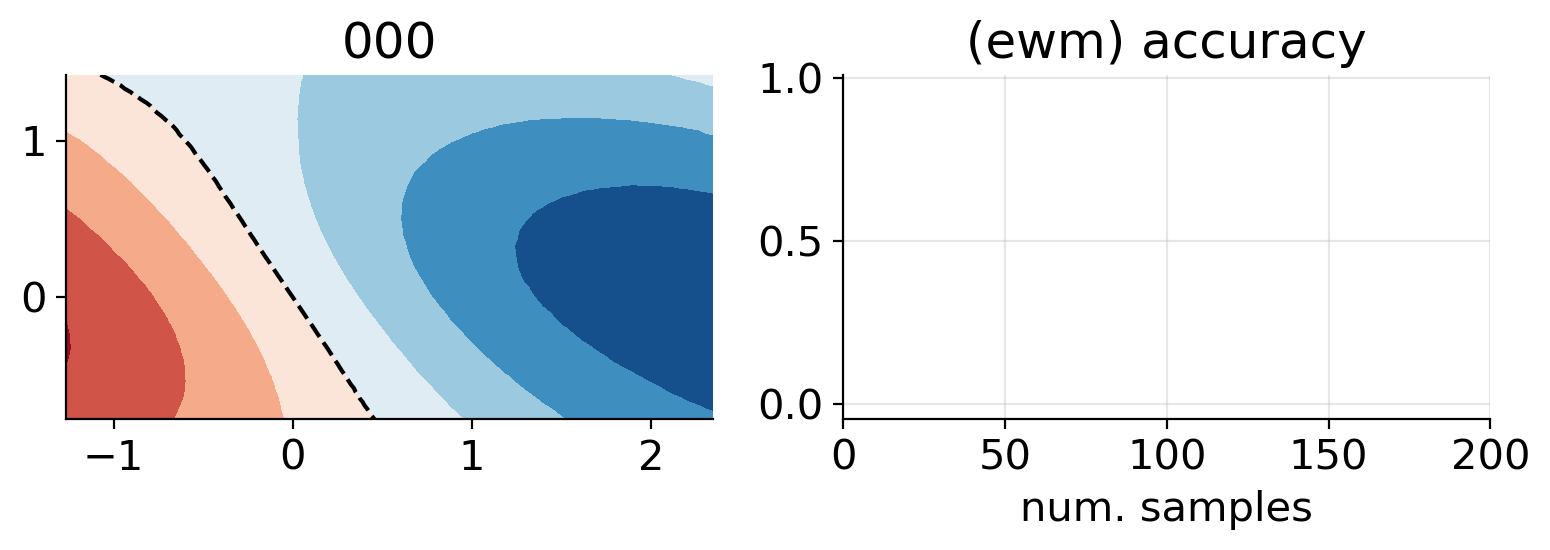

In [20]:
def animate(t, ax):
    print(t, end="\r")
    for axi in ax:
        axi.cla()
    Z = agent.link_fn(means[t], einops.rearrange(Xgrid, "d i j -> i j d")).squeeze()
    Z = np.array(Z)

    ax[0].contour(*Xgrid, Z, levels=0, colors="black", linestyles="--")
    ax[0].contourf(*Xgrid, Z, cmap=cmap)
    tmin = (t // n_samples) * n_samples
    ax[0].scatter(*X[tmin:t].T, c=y[tmin:t], cmap="bone_r", edgecolor="black")
    ax[0].set_xlim(xmin, xmax)
    ax[0].set_ylim(ymin, ymax)
    ax[0].set_title(f"{t:=03}")

    
    errs.ewm(span=50).mean()[:t].plot(ax=ax[1], c="black")
    ax[1].grid(alpha=0.3)
    ax[1].set_xlim(0, len(y))
    ax[1].set_title("(ewm) accuracy")
    ax[1].set_xlabel("num. samples")
    plt.tight_layout()


fig, ax = plt.subplots(1, 2, figsize=(8, 3))
animation = FuncAnimation(fig, partial(animate, ax=ax), frames=np.arange(len(y)))
animation.save("moons-c-static.gif", fps=15)

# Changepoints!

In [35]:
n_samples = 200
n_rotations = 5
(X, y, rads), test = make_rotating_moons(
    n_samples, 0, n_rotations=n_rotations, noise=0.2, seed=314, max_angle=270
)

In [36]:
xmin, ymin = X.min(axis=0)
xmax, ymax = X.max(axis=0)
Xgrid = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

## Plotting regimes

In [37]:
X.shape

(1000, 2)

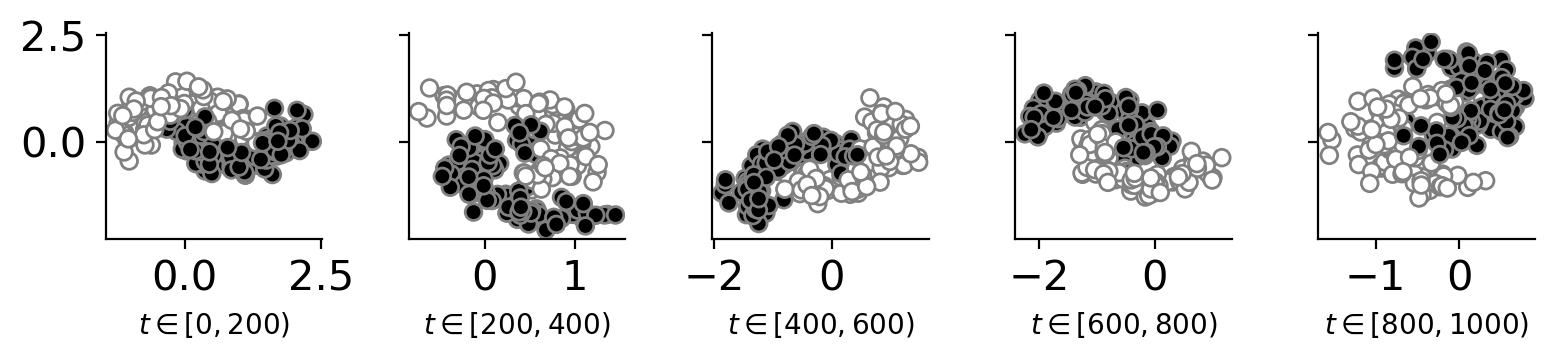

In [418]:
fig, ax = plt.subplots(1, n_rotations, figsize=(8, 2), sharey=True)
for i, axi in enumerate(ax):
    tinit, tend = i * n_samples, (i + 1) * n_samples
    tslice = slice(tinit, tend)
    Xsub = X[tslice]
    ysub = y[tslice]
    axi.set_xlabel(rf"$t \in [{tinit}, {tend})$", fontsize=10)
    axi.scatter(*Xsub.T, c=ysub, cmap="bone_r", edgecolor="gray")
plt.tight_layout()
plt.savefig("mooons-dataset-split.png", dpi=200, bbox_inches="tight")

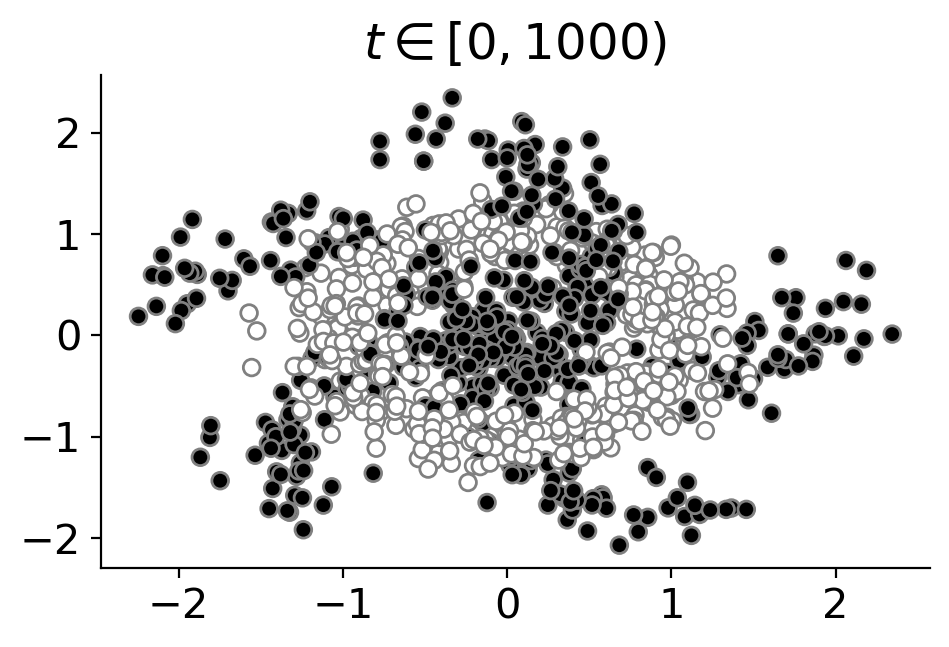

In [419]:
fig, ax = plt.subplots(figsize=(5, 3.5))
ax.set_title(fr"$t \in [0, {n_samples * n_rotations})$")
ax.scatter(*X.T, c=y, cmap="bone_r", edgecolor="gray")
plt.tight_layout()
plt.savefig("moons-dataset-full.png", dpi=200, bbox_inches="tight")

## C-static

In [365]:
frames = np.arange(0, len(y), 4)
len(frames)

250

In [366]:
params_init = model.init(key, X)

In [367]:
agent = BernoulliFilter(model.apply, dynamics_covariance=0.0, eps=0.0)
bel_init = agent.init_bel(params_init)

In [368]:
def callback(bel, bel_prior, y, x):
    yhat = agent.link_fn(bel_prior.mean, x)
    return {
        "yhat": yhat,
        "mean": bel_prior.mean
    }

In [369]:
bel_final, hist = agent.scan(bel_init, y, X, callback)
hist = jax.tree.map(np.array, hist)
means = hist["mean"]

In [370]:
yhat = jax.nn.sigmoid(hist["yhat"]) > 0.5

In [371]:
(yhat.ravel() == y).mean()

Array(0.65900004, dtype=float32)

In [372]:
errs_ccst = (yhat.ravel() == y)
X, y, errs_ccst = jax.tree.map(np.array, (X, y, errs_ccst))
errs_ccst = pd.Series(errs_ccst) * 1.0

MovieWriter ffmpeg unavailable; using Pillow instead.


096

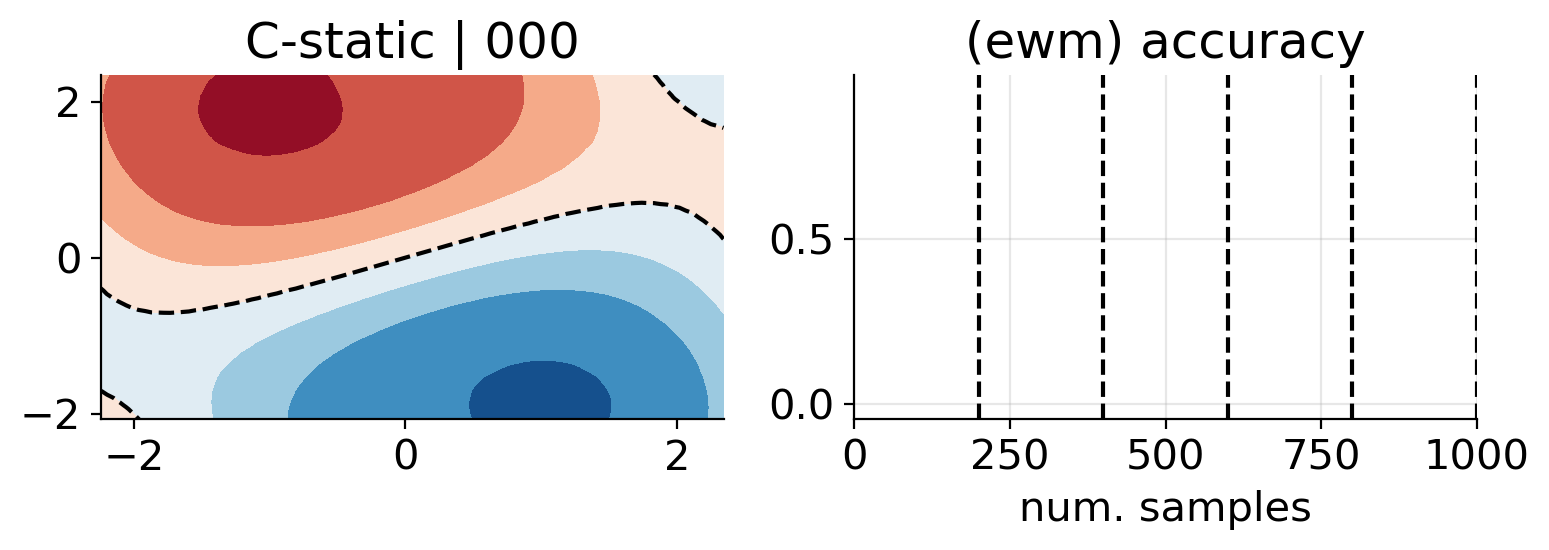

In [373]:
def animate(t, ax):
    print(t, end="\r")
    for axi in ax:
        axi.cla()
    Z = agent.link_fn(means[t], einops.rearrange(Xgrid, "d i j -> i j d")).squeeze()
    Z = np.array(Z)

    ax[0].contour(*Xgrid, Z, levels=0, colors="black", linestyles="--")
    ax[0].contourf(*Xgrid, Z, cmap=cmap)
    tmin = (t // n_samples) * n_samples
    ax[0].scatter(*X[tmin:t].T, c=y[tmin:t], cmap="bone_r", edgecolor="black")
    ax[0].set_xlim(xmin, xmax)
    ax[0].set_ylim(ymin, ymax)
    ax[0].set_title(f"C-static | {t:=03}")

    for i in range(n_rotations):
        ax[1].axvline(x=(i+1) * n_samples, c="black", linestyle="--")

    
    errs_ccst.ewm(span=50).mean()[:t].plot(ax=ax[1], c="black")
    ax[1].grid(alpha=0.3)
    ax[1].set_xlim(0, len(y))
    ax[1].set_title("(ewm) accuracy")
    ax[1].set_xlabel("num. samples")
    plt.tight_layout()


fig, ax = plt.subplots(1, 2, figsize=(8, 3))
animation = FuncAnimation(fig, partial(animate, ax=ax), frames=frames)
animation.save("changes-moons-c-static.gif", fps=15)

## RLPR to the rescue?

In [374]:
from rebayes_mini.methods.adaptive import ExpfamRLPR

In [375]:
agent_base = BernoulliFilter(model.apply, 0.0, eps=0.0)
agent = ExpfamRLPR(p_change=0.22, K=1, filter=agent_base)
bel_init = agent.init_bel(params_init, cov=1.0, log_joint_init=0.0)

In [376]:
def callback(bel, bel_prior, y, x):
    yhat = jax.vmap(agent.filter.link_fn, in_axes=(0, None))(bel_prior.mean, x)
    return {
        "yhat": yhat,
        "mean": bel_prior.mean,
        "runlenght": bel.runlength,
        "joint": bel.log_joint,
    }

In [377]:
bel_final, hist = agent.scan(y[:, None], X, bel_init, callback)
hist = jax.tree.map(np.array, hist)
means = hist["mean"]

In [378]:
yhat = jax.nn.sigmoid(hist["yhat"]) > 0.5

errs_rlpr = (yhat.ravel() == y)
X, y, errs_rlpr = jax.tree.map(np.array, (X, y, errs_rlpr))
errs_rlpr = pd.Series(errs_rlpr) * 1.0

In [379]:
(yhat.ravel() == y).mean()

Array(0.874, dtype=float32)

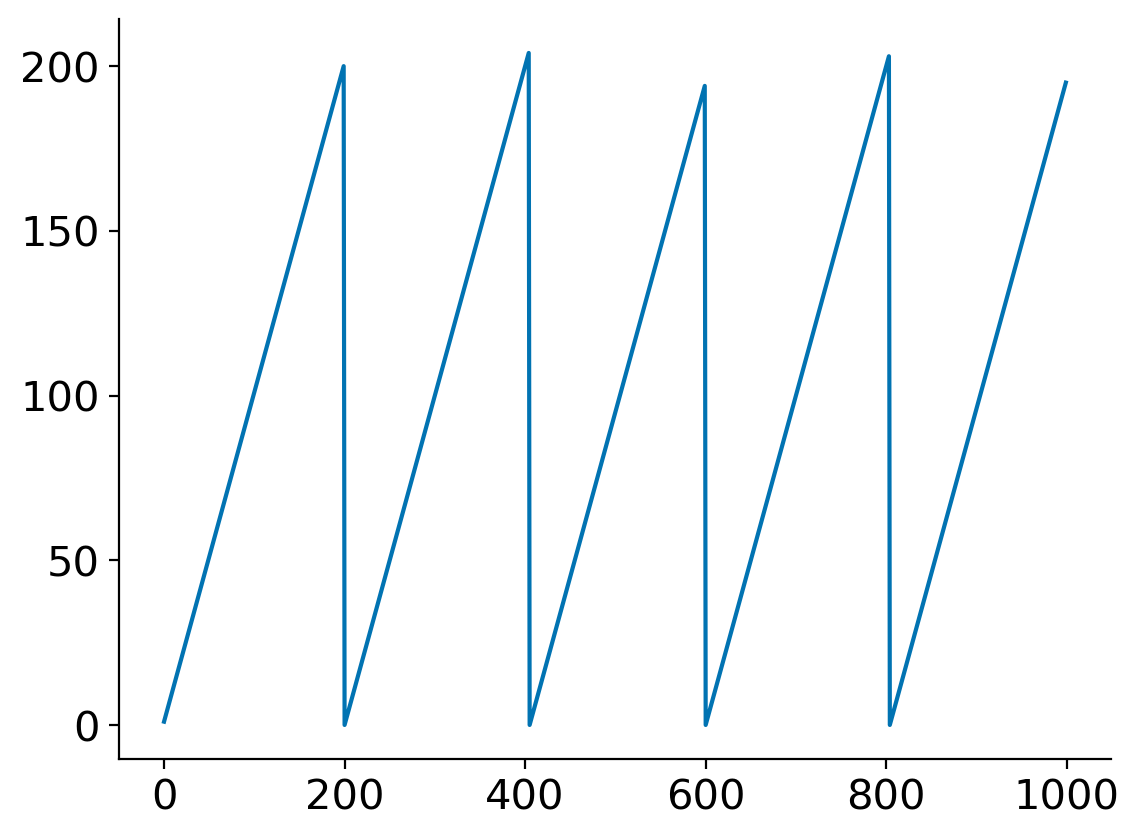

In [380]:
plt.plot(hist["runlenght"])

MovieWriter ffmpeg unavailable; using Pillow instead.


096

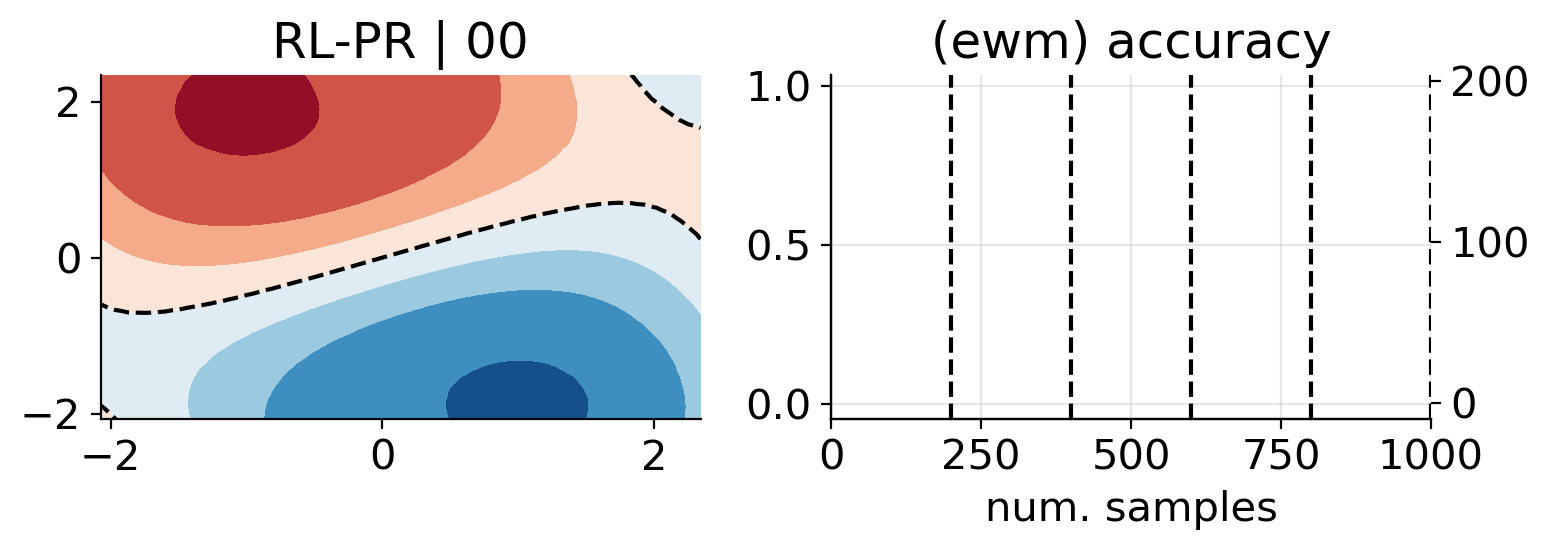

In [381]:
def animate(t, ax):
    print(t, end="\r")
    for axi in ax:
        axi.cla()
    Z = agent.filter.link_fn(means[t,0], einops.rearrange(Xgrid, "d i j -> i j d")).squeeze()
    Z = np.array(Z)
    
    ax[0].contour(*Xgrid, Z, levels=0, colors="black", linestyles="--")
    ax[0].contourf(*Xgrid, Z, cmap=cmap)
    tmin = (t // n_samples) * n_samples
    ax[0].scatter(*X[tmin:t].T, c=y[tmin:t], cmap="bone_r", edgecolor="black")
    ax[0].set_xlim(xmin, xmax)
    ax[0].set_xlim(ymin, ymax)
    ax[0].set_title(f"RL-PR | {t:=02}")

    for i in range(n_rotations):
        ax[1].axvline(x=(i+1) * n_samples, c="black", linestyle="--")

    ax2.cla()
    errs_rlpr.ewm(span=50).mean()[:t].plot(ax=ax[1], c="black")
    ax[1].grid(alpha=0.3)
    ax[1].set_xlim(0, len(y))
    ax[1].set_title("(ewm) accuracy")
    ax[1].set_xlabel("num. samples")
    ax2.plot(hist["runlenght"][:t], c="crimson", alpha=0.6)
    ax2.set_ylim(top=hist["runlenght"].max())
    
    plt.tight_layout()


fig, ax = plt.subplots(1, 2, figsize=(8, 3))
ax2 = ax[1].twinx()

animation = FuncAnimation(fig, partial(animate, ax=ax), frames=frames)
animation.save("changes-moons-rl-pr.gif", fps=15)

## CPP-OU

In [382]:
from rebayes_mini.methods.adaptive import ExpfamEBA

In [383]:
agent_base = BernoulliFilter(model.apply, 0.0, eps=0.0)
agent = ExpfamEBA(
    n_inner=3, ebayes_lr=1e-3, filter=agent_base,
    state_drift=1.5, deflate_mean=True, deflate_covariance=True
)
bel_init = agent.init_bel(params_init, cov=1.0)

In [384]:
def callback(bel, bel_prior, y, x):
    yhat = agent.filter.link_fn(bel_prior.mean, x)
    return {
        "yhat": yhat,
        "mean": bel_prior.mean,
        "posterior": jnp.exp(-bel.eta/2),
    }

In [385]:
bel_final, hist = agent.scan(y[:, None], X, bel_init, callback)
hist = jax.tree.map(np.array, hist)
means = hist["mean"]

In [386]:
yhat = jax.nn.sigmoid(hist["yhat"]) > 0.5
errs_cppou = (yhat.ravel() == y)
errs_cppou.mean()

Array(0.731, dtype=float32)

In [387]:
X, y, errs_cppou = jax.tree.map(np.array, (X, y, errs_cppou))
errs_cppou = pd.Series(errs_cppou) * 1.0

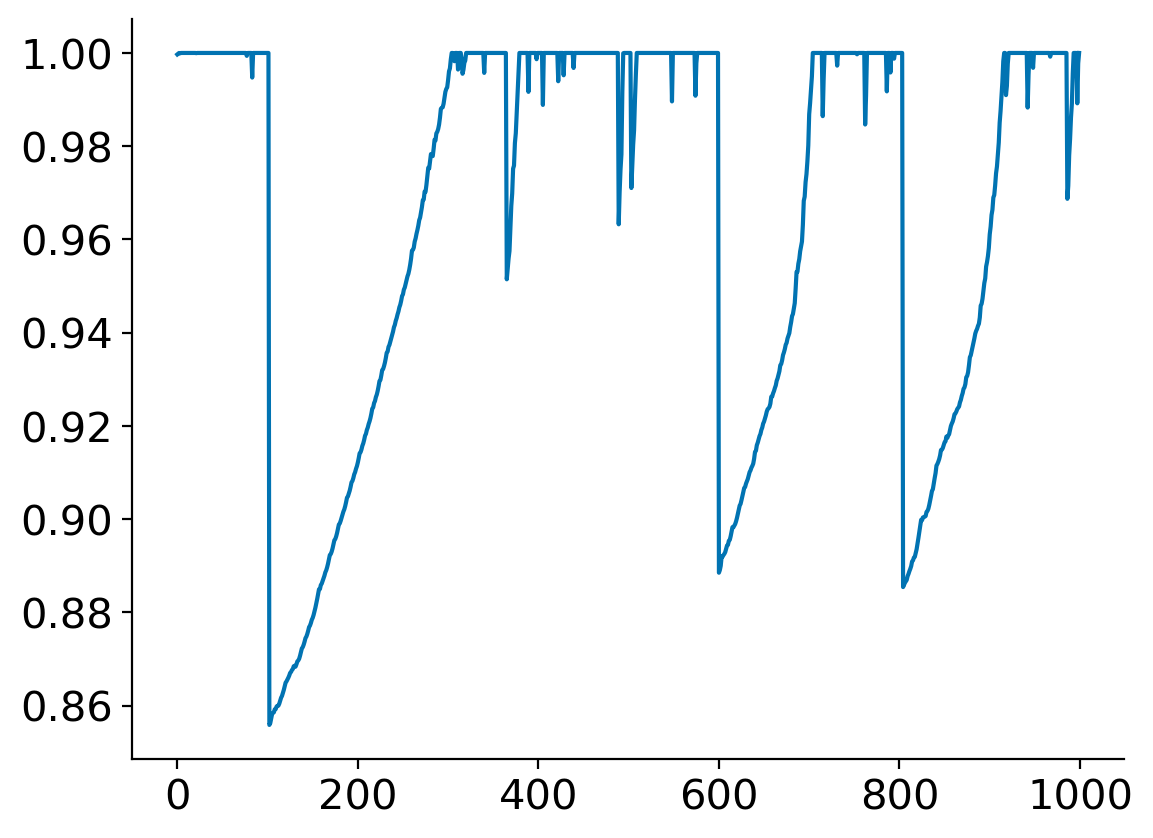

In [388]:
plt.plot(hist['posterior'])

MovieWriter ffmpeg unavailable; using Pillow instead.


096

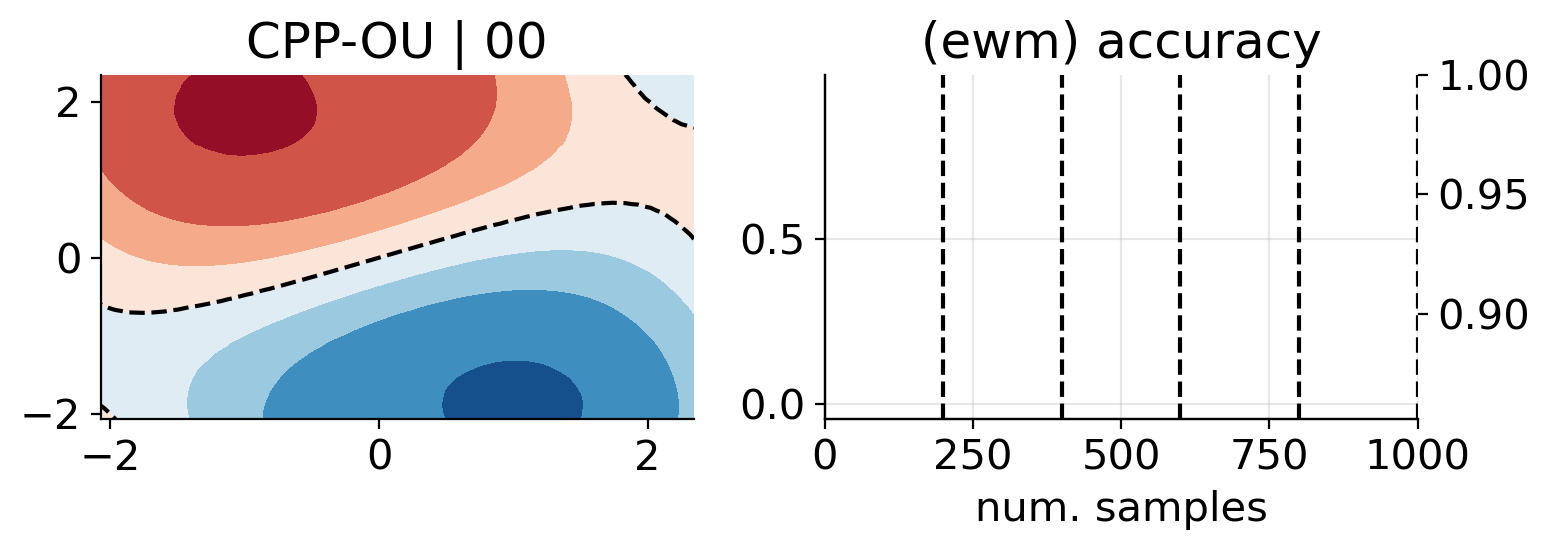

In [389]:
def animate(t, ax):
    print(t, end="\r")
    for axi in ax:
        axi.cla()
    Z = agent.filter.link_fn(means[t], einops.rearrange(Xgrid, "d i j -> i j d")).squeeze()
    Z = np.array(Z)

    ax[0].contour(*Xgrid, Z, levels=0, colors="black", linestyles="--")
    ax[0].contourf(*Xgrid, Z, cmap=cmap)
    tmin = (t // n_samples) * n_samples
    ax[0].scatter(*X[tmin:t].T, c=y[tmin:t], cmap="bone_r", edgecolor="black")
    ax[0].set_xlim(xmin, xmax)
    ax[0].set_xlim(ymin, ymax)
    ax[0].set_title(f"CPP-OU | {t:=02}")

    for i in range(n_rotations):
        ax[1].axvline(x=(i+1) * n_samples, c="black", linestyle="--")

    ax2.cla()
    errs_cppou.ewm(span=50).mean()[:t].plot(ax=ax[1], c="black")
    ax[1].grid(alpha=0.3)
    ax[1].set_xlim(0, len(y))
    ax[1].set_title("(ewm) accuracy")
    ax[1].set_xlabel("num. samples")
    
    ax2.plot(hist["posterior"][:t], c="crimson", alpha=0.6)
    ax2.set_ylim(top=1.0, bottom=hist["posterior"].min())

    plt.tight_layout()

fig, ax = plt.subplots(1, 2, figsize=(8, 3))
ax2 = ax[1].twinx()
animation = FuncAnimation(fig, partial(animate, ax=ax), frames=frames)
animation.save("changes-moons-cpp-ou.gif", fps=15)

## C-ACI

In [390]:
params_init = model.init(key, X)

In [391]:
agent = BernoulliFilter(model.apply, dynamics_covariance=1e-4, eps=0.0)
bel_init = agent.init_bel(params_init)

In [392]:
def callback(bel, bel_prior, y, x):
    yhat = agent.link_fn(bel_prior.mean, x)
    return {
        "yhat": yhat,
        "mean": bel_prior.mean
    }

In [393]:
bel_final, hist = agent.scan(bel_init, y, X, callback)
hist = jax.tree.map(np.array, hist)
means = hist["mean"]

In [394]:
yhat = jax.nn.sigmoid(hist["yhat"]) > 0.5

In [395]:
(yhat.ravel() == y).mean()

Array(0.85300004, dtype=float32)

In [396]:
errs_caci = (yhat.ravel() == y)
X, y, errs_caci = jax.tree.map(np.array, (X, y, errs_caci))
errs_caci = pd.Series(errs_caci) * 1.0

In [397]:
def animate(t, ax):
    print(t, end="\r")
    for axi in ax:
        axi.cla()
    Z = agent.link_fn(means[t], einops.rearrange(Xgrid, "d i j -> i j d")).squeeze()
    Z = np.array(Z)

    ax[0].contour(*Xgrid, Z, levels=0, colors="black", linestyles="--")
    ax[0].contourf(*Xgrid, Z, cmap=cmap)
    tmin = (t // n_samples) * n_samples
    ax[0].scatter(*X[tmin:t].T, c=y[tmin:t], cmap="bone_r", edgecolor="black")
    ax[0].set_xlim(xmin, xmax)
    ax[0].set_ylim(ymin, ymax)
    ax[0].set_title(f"C-ACI | {t:=03}")

    for i in range(n_rotations):
        ax[1].axvline(x=(i+1) * n_samples, c="black", linestyle="--")

    
    errs_caci.ewm(span=50).mean()[:t].plot(ax=ax[1], c="black")
    ax[1].grid(alpha=0.3)
    ax[1].set_xlim(0, len(y))
    ax[1].set_title("(ewm) accuracy")
    ax[1].set_xlabel("num. samples")
    plt.tight_layout()

MovieWriter ffmpeg unavailable; using Pillow instead.


096

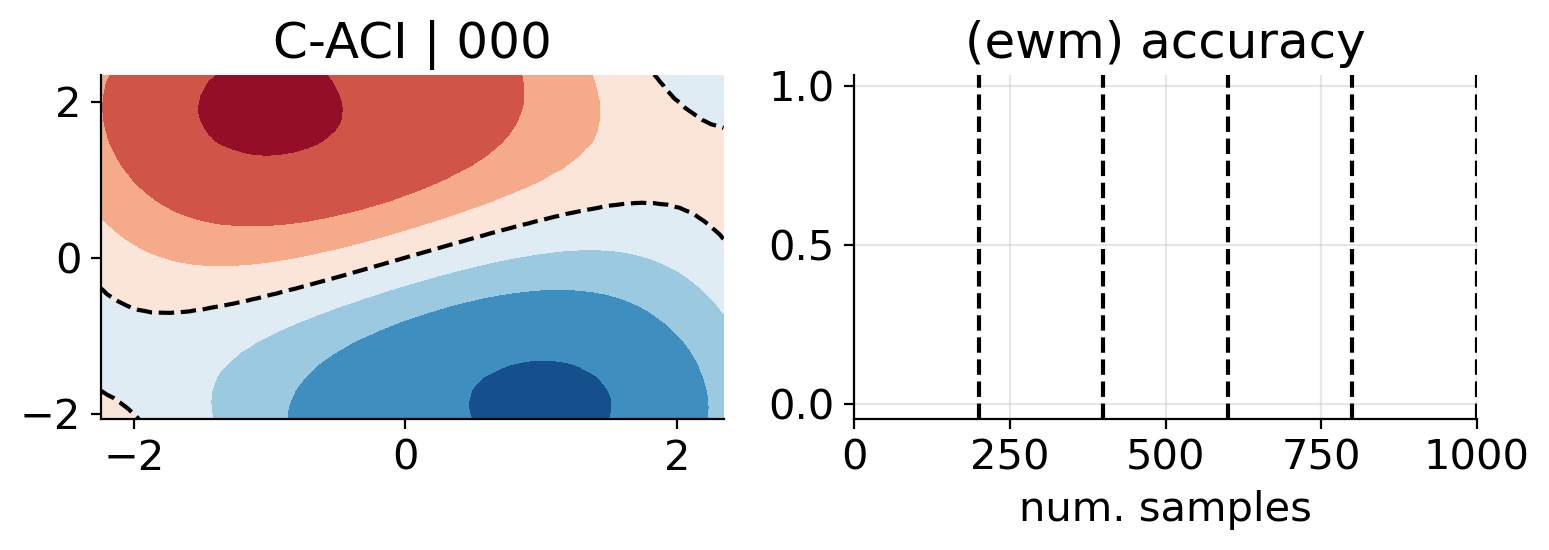

In [398]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
animation = FuncAnimation(fig, partial(animate, ax=ax), frames=frames)
animation.save("changes-moons-c-aci.gif", fps=15)

## RL-SPR to the rescue?

In [399]:
from rebayes_mini.methods.adaptive import ExpfamRLOUPR

In [400]:
agent_base = BernoulliFilter(model.apply, 0.0, eps=0.0)
agent = ExpfamRLOUPR(p_change=0.04, shock=0.01, deflate_mean=False, filter=agent_base)
bel_init = agent.init_bel(params_init, cov=1.0, log_posterior_init=0.0)

In [401]:
def callback(bel, bel_prior, y, x):
    yhat = agent.filter.link_fn(bel_prior.mean, x)
    return {
        "yhat": yhat,
        "mean": bel_prior.mean,
        "runlenght": bel.runlength,
        "joint": bel.log_posterior,
    }

In [402]:
bel_final, hist = agent.scan(y[:, None], X, bel_init, callback)
hist = jax.tree.map(np.array, hist)
hist["posterior"] = np.exp(hist["joint"])
means = hist["mean"]

In [403]:
yhat = jax.nn.sigmoid(hist["yhat"]) > 0.5

errs_rlpr = (yhat.ravel() == y)
X, y, errs_rlspr = jax.tree.map(np.array, (X, y, errs_rlpr))
errs_rlspr = pd.Series(errs_rlpr) * 1.0

In [404]:
(yhat.ravel() == y).mean()

Array(0.85, dtype=float32)

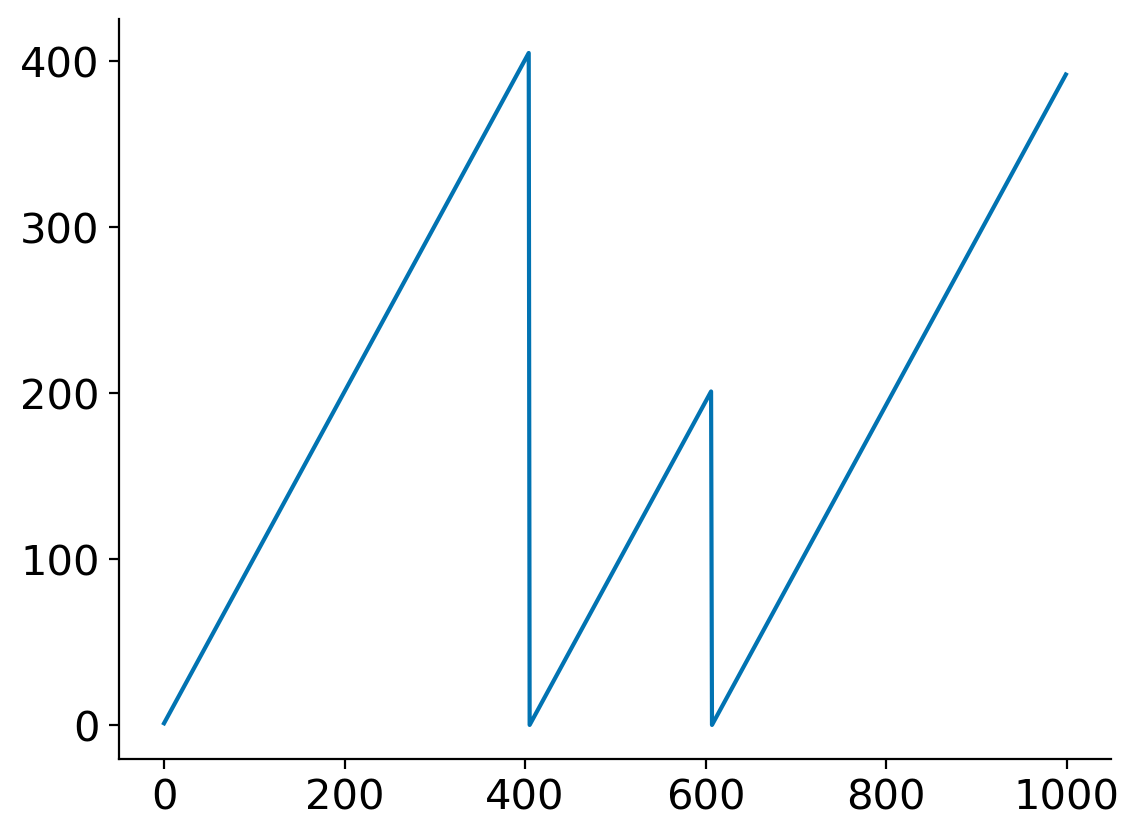

In [405]:
plt.plot(hist["runlenght"])

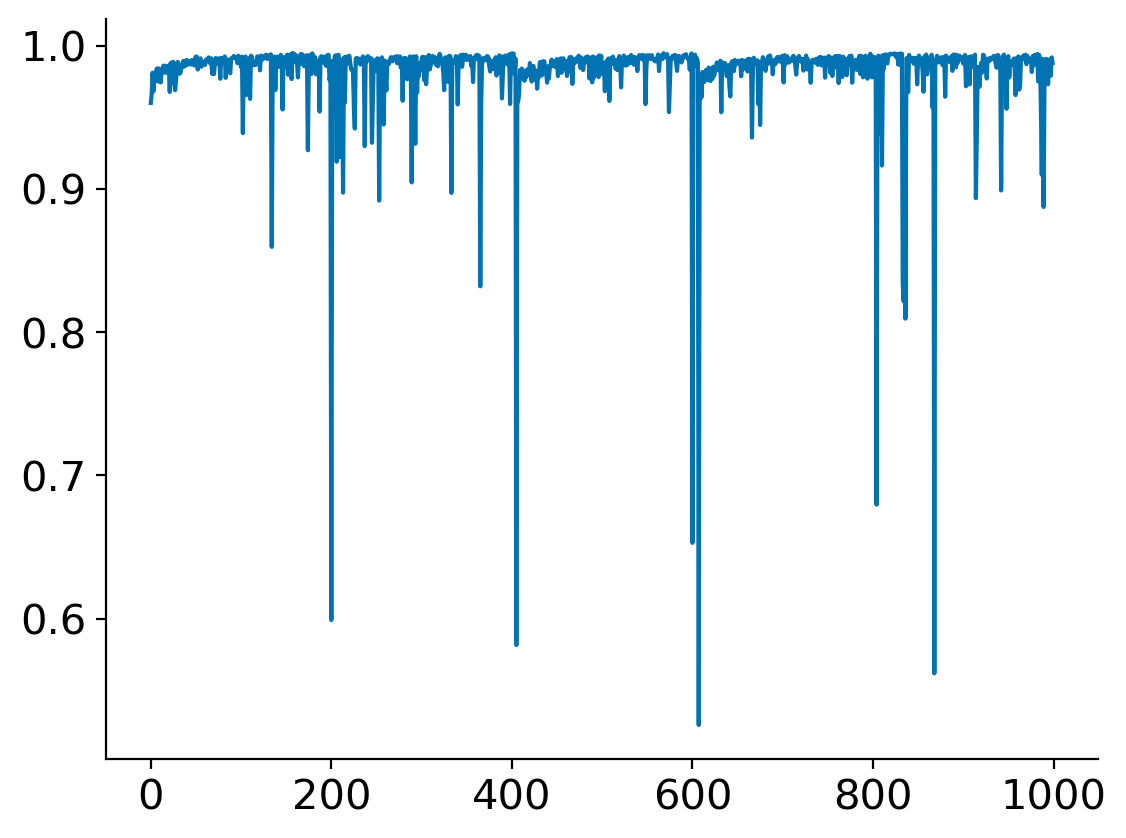

In [406]:
plt.plot(jnp.exp(hist["joint"]))

In [407]:
def animate(t, ax):
    print(t, end="\r")
    for axi in ax:
        axi.cla()
    Z = agent.filter.link_fn(means[t], einops.rearrange(Xgrid, "d i j -> i j d")).squeeze()
    Z = np.array(Z)

    ax[0].contour(*Xgrid, Z, levels=0, colors="black", linestyles="--")
    ax[0].contourf(*Xgrid, Z, cmap=cmap)
    tmin = (t // n_samples) * n_samples
    ax[0].scatter(*X[tmin:t].T, c=y[tmin:t], cmap="bone_r", edgecolor="black")
    ax[0].set_xlim(xmin, xmax)
    ax[0].set_ylim(ymin, ymax)
    ax[0].set_title(f"RL-OUPR | {t:=03}")

    for i in range(n_rotations):
        ax[1].axvline(x=(i+1) * n_samples, c="black", linestyle="--")

    
    ax2.cla()
    errs_rlspr.ewm(span=50).mean()[:t].plot(ax=ax[1], c="black")
    ax[1].grid(alpha=0.3)
    ax[1].set_xlim(0, len(y))
    ax[1].set_title("(ewm) accuracy")
    ax[1].set_xlabel("num. samples")
    
    ax2.plot(hist["posterior"][:t], c="crimson", alpha=0.6)
    ax2.set_ylim(top=1.0, bottom=hist["posterior"].min())

    
    plt.tight_layout()

MovieWriter ffmpeg unavailable; using Pillow instead.


096

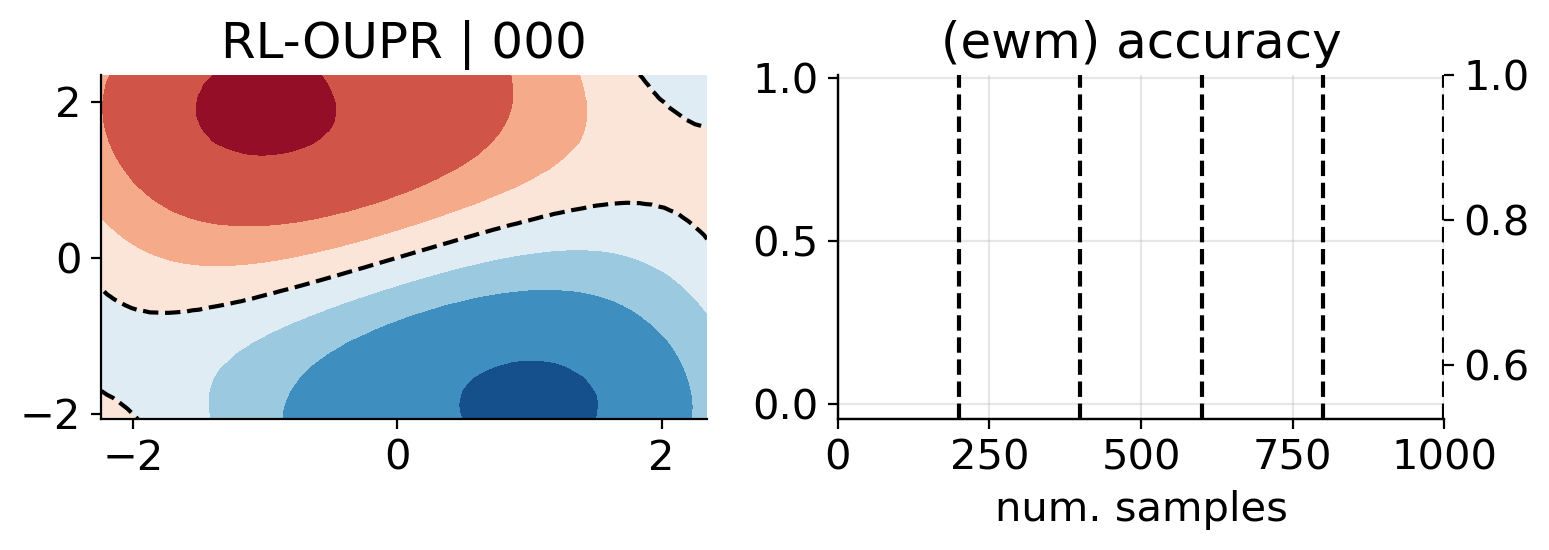

In [408]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
ax2 = ax[1].twinx()
animation = FuncAnimation(fig, partial(animate, ax=ax), frames=frames)
animation.save("changes-moons-rl-oupr.gif", fps=15)

## All errors

In [409]:
errs_all = pd.DataFrame({
    "C-Static": errs_ccst,
    "RL-PR": errs_rlpr,
    "CPP-OU": errs_cppou,
    "C-ACI": errs_caci,
    "RL-OUPR": errs_rlspr,
})

# errs_all.columns = [r"$\texttt{" + c + "}$" for c in errs_all.columns]

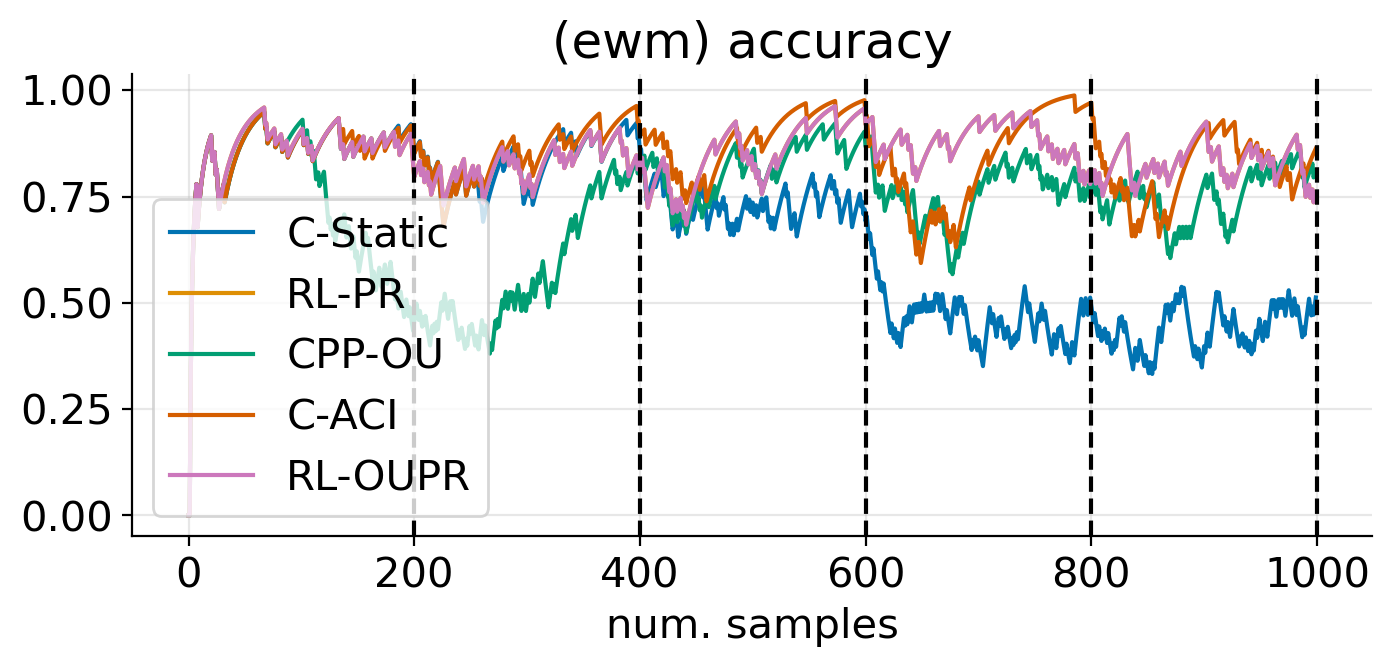

In [410]:
fig, ax = plt.subplots(figsize=(8, 3))

errs_all.ewm(span=50).mean().plot(ax=ax)

for i in range(n_rotations):
    plt.axvline(x=(i+1) * n_samples, c="black", linestyle="--")

plt.title("(ewm) accuracy")
plt.xlabel("num. samples")
plt.grid(alpha=0.3)
plt.savefig("changes-mooons-comparison.png", dpi=200)